# Journal Recommendation - Figure Generator

In [1]:
from collections import Counter
import itertools
import os
from pathlib import Path
import pickle
import random

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from tqdm import tqdm

from saucie_modules import SAUCIE, Loader
import tensorflow.compat.v1 as tf

import plotnine as p9

In [2]:
# Set up porting from python to R
# and R to python :mindblown:

import rpy2.rinterface
%load_ext rpy2.ipython

# Plot Accuracy Results

In [3]:
results = [
    {"value":.00517, "model":"random_baseline", "distance":"N/A", "dataset":"train (cross validation)"},
    {"value":.39982, "model":"paper_paper", "distance":"euclidean", "dataset":"train (cross validation)"},
    {"value":.37340, "model":"centroid", "distance":"euclidean", "dataset":"train (cross validation)"},
    {"value":.39824, "model":"paper_paper", "distance":"manhattan", "dataset":"train (cross validation)"},
    {"value":.39824, "model":"centroid", "distance":"manhattan", "dataset":"train (cross validation)"},
    {"value":.00445, "model":"random_baseline", "distance":"N/A", "dataset":"test"},
    {"value":.20638, "model":"paper_paper", "distance":"euclidean", "dataset":"test"},
    {"value":.21636, "model":"centroid", "distance":"euclidean", "dataset":"test"},
    {"value":.20380, "model":"paper_paper", "distance":"manhattan", "dataset":"test"},
    {"value":.21523, "model":"centroid", "distance":"manhattan", "dataset":"test"}
]

In [4]:
result_df = pd.DataFrame.from_records(results)

result_df['dataset'] = pd.Categorical(
    result_df.dataset.tolist(), 
    categories=['train (cross validation)', 'test']
)

result_df.head()

,value,model,distance,dataset
0,0.00517,random_baseline,N/A,train (cross validation)
1,0.39982,paper_paper,euclidean,train (cross validation)
2,0.37340,centroid,euclidean,train (cross validation)
3,0.39824,paper_paper,manhattan,train (cross validation)
4,0.39824,centroid,manhattan,train (cross validation)


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/knn_result.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/knn_result.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


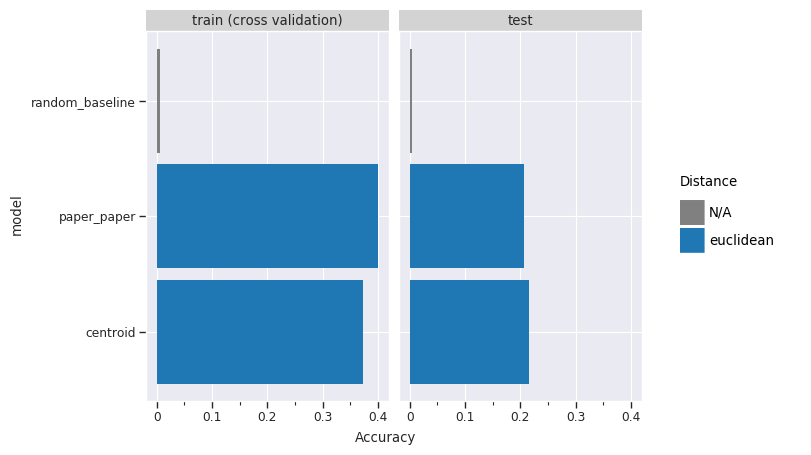

<ggplot: (8728204951998)>


In [5]:
g = (
    p9.ggplot(result_df.query("distance in ['euclidean', 'N/A']"), p9.aes(x="model", y="value"))
    + p9.geom_col(p9.aes(fill="factor(distance)"), position="dodge")
    + p9.coord_flip()
    + p9.facet_wrap("dataset")
    + p9.scale_fill_manual(["#808080", "#1f78b4"])
    + p9.theme_seaborn(context='paper')
    + p9.labs(
        y="Accuracy",
        fill="Distance"
    )
)

g.save(
    Path("output")/
    Path("figures")/
    Path("knn_result.svg"), 
    dpi=500
)

g.save(
    Path("output")/
    Path("figures")/
    Path("knn_result.png"),
    dpi=500
)

print(g)

# Generate 2D Visualization

## Use SAUCIE on PMC

### Set Up Grid Evaluation

In [6]:
# Set the seeds to fix the reproducebility issue
def set_seeds():
    np.random.seed(100)
    tf.reset_default_graph()
    tf.set_random_seed(seed=100)
    os.environ['PYTHONHASHSEED'] = str(100)
    random.seed(100)

In [7]:
def run_saucie_param_grid(
    dataset, learning_rate_grid = [1e-3], 
    lambda_c_grid=[0], lambda_d_grid=[0], 
    steps_grid=[1000]
):
    plot_df = pd.DataFrame(
        [],
        columns=["dim1", "dim2", "lambda_c", "lambda_d", "journal"]
    )
    
    hyper_param_grid = itertools.product(
        learning_rate_grid, lambda_c_grid, 
        lambda_d_grid, steps_grid
    )
    
    for learning_rate, lambda_c, lambda_d, steps in tqdm(hyper_param_grid):

        set_seeds()

        saucie = SAUCIE(
            dataset.shape[1]-2, 
            lambda_b=0, lambda_c=lambda_c, lambda_d=lambda_d,
            learning_rate=learning_rate,
            save_folder="output/model"
        )

        loadtrain = Loader(
            dataset.drop(["journal", "document"], axis=1).values, 
            pd.Categorical(dataset["journal"].values).codes, 
            shuffle=True
        )

        saucie.train(loadtrain, steps=steps)
        
        loadeval = Loader(
            dataset.drop(["journal", "document"], axis=1).values, 
            pd.Categorical(dataset["journal"].values).codes, 
            shuffle=False
        )
        
        embedding = saucie.get_embedding(loadeval)
        
        plot_df = plot_df.append(
            pd.DataFrame(embedding[0], columns=["dim1", "dim2"])
            .assign(
                steps=steps,
                learning_rate=learning_rate,
                lambda_c=lambda_c,
                lambda_d=lambda_d,
                journal=dataset.journal.tolist()
            )
        )
        
    return plot_df

### Load the data

In [8]:
full_paper_dataset = pd.read_csv(
    Path("output/paper_dataset")/
    Path("paper_dataset_full.tsv.xz"), 
    sep="\t"
)
full_paper_dataset.head()

,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,Environ_Health,PMC1552054,-0.428596,0.004477,-0.153677,0.059131,-0.394598,-0.066383,0.358798,-0.245809,...,-0.067994,0.033121,-0.077121,-0.433617,-1.111247,-0.405260,0.293903,0.613155,-0.500204,-0.214057
1,Environ_Health,PMC1226148,-0.434013,-0.185516,-0.070654,0.488759,-0.280275,0.042681,0.116685,0.037062,...,0.318905,-0.065244,0.159258,-0.380412,-0.665559,-0.485417,0.180982,0.523053,-0.485158,-0.251244
2,Environ_Health,PMC5635510,-0.248388,0.118660,-0.103008,0.267721,0.278939,-0.220584,0.089593,-0.159638,...,0.081127,-0.110091,-0.031617,-0.188741,-0.936947,-0.461118,0.618781,0.647195,-0.270240,-0.409643
3,Environ_Health,PMC3125232,-0.507224,0.024099,-0.039696,-0.171992,0.371326,-0.137797,-0.202616,-0.156994,...,-0.218274,-0.022597,-0.028885,-0.250560,-1.140730,-0.568136,0.482088,0.899122,-0.250971,-0.592976
4,Environ_Health,PMC3533997,-0.424435,0.175519,-0.048797,0.178023,-0.042913,-0.282377,0.317917,-0.007002,...,-0.111805,-0.262620,-0.187817,-0.463804,-1.308874,-0.352892,0.251982,0.550853,-0.659678,-0.614042


In [9]:
journal_counts = full_paper_dataset.journal.value_counts()
journal_counts[journal_counts > 1000][-4:]

Case_Rep_Med              1018
Database_(Oxford)         1016
Mol_Ther_Nucleic_Acids    1013
Front_Comput_Neurosci     1010
Name: journal, dtype: int64

In [10]:
full_paper_dataset_subset = (
    full_paper_dataset
    .query(
        "journal in "
        f"{journal_counts[journal_counts > 1000][-4:].index.tolist()}"
    )
)
full_paper_dataset_subset.head()

,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
230197,Case_Rep_Med,PMC4355551,0.084253,0.335070,-0.355859,0.228344,0.086136,-0.097942,0.388425,0.040841,...,0.425013,0.520189,0.064601,-0.057251,-0.814639,0.023971,0.613246,-0.093052,-0.122590,0.017877
230198,Case_Rep_Med,PMC3970245,-0.129840,-0.054962,-0.445179,0.462894,0.154843,-0.042064,0.189078,0.388115,...,0.441430,0.296369,0.188502,-0.038912,-0.722607,-0.069703,0.429826,0.184142,-0.209348,-0.166691
230199,Case_Rep_Med,PMC3693114,-0.282267,0.131550,-0.376887,0.089251,-0.265588,-0.002342,0.515390,0.275363,...,0.304123,0.305682,-0.055390,-0.257230,-0.985788,-0.428273,0.289220,0.401388,-0.362230,0.023827
230200,Case_Rep_Med,PMC4138950,0.008634,0.292222,-0.259092,0.039999,0.067902,-0.335933,0.237287,0.401293,...,0.466729,0.257969,-0.081949,-0.224460,-0.889097,-0.372319,0.542455,0.298281,-0.310256,-0.341932
230201,Case_Rep_Med,PMC3867941,0.023984,0.159218,-0.283456,0.487455,-0.154615,-0.450449,0.410288,0.358524,...,0.295872,0.441439,0.007222,-0.289212,-1.055683,-0.217976,0.521094,0.129971,-0.346588,-0.173344


### Evaluate the Grid

This section involves tuning the hyperparameters of the SAUCIE network. This network sues a shallow autoencoder to project high dimensional data into a low dimensional space. This network takes in three lambda parameters along with a learning rate and number of steps. The plots in this section show the results of different parameters being tunes on a small subset of PMC papers (randomly sampled from four different journals). The best parameters for this model separates the four journals into their own distinct clusters.

In [11]:
lambda_c_grid = np.linspace(1e-6, 1, num=5)
lambda_d_grid = np.linspace(1e-6, 1, num=5)

In [12]:
set_seeds()
plot_df = run_saucie_param_grid(
    full_paper_dataset_subset,
    lambda_c_grid=lambda_c_grid,
    lambda_d_grid=lambda_d_grid
)

0it [00:00, ?it/s]


Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.



Instructions for updating:
keep_dims is deprecated, use keepdims instead



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








25it [05:25, 13.02s/it]


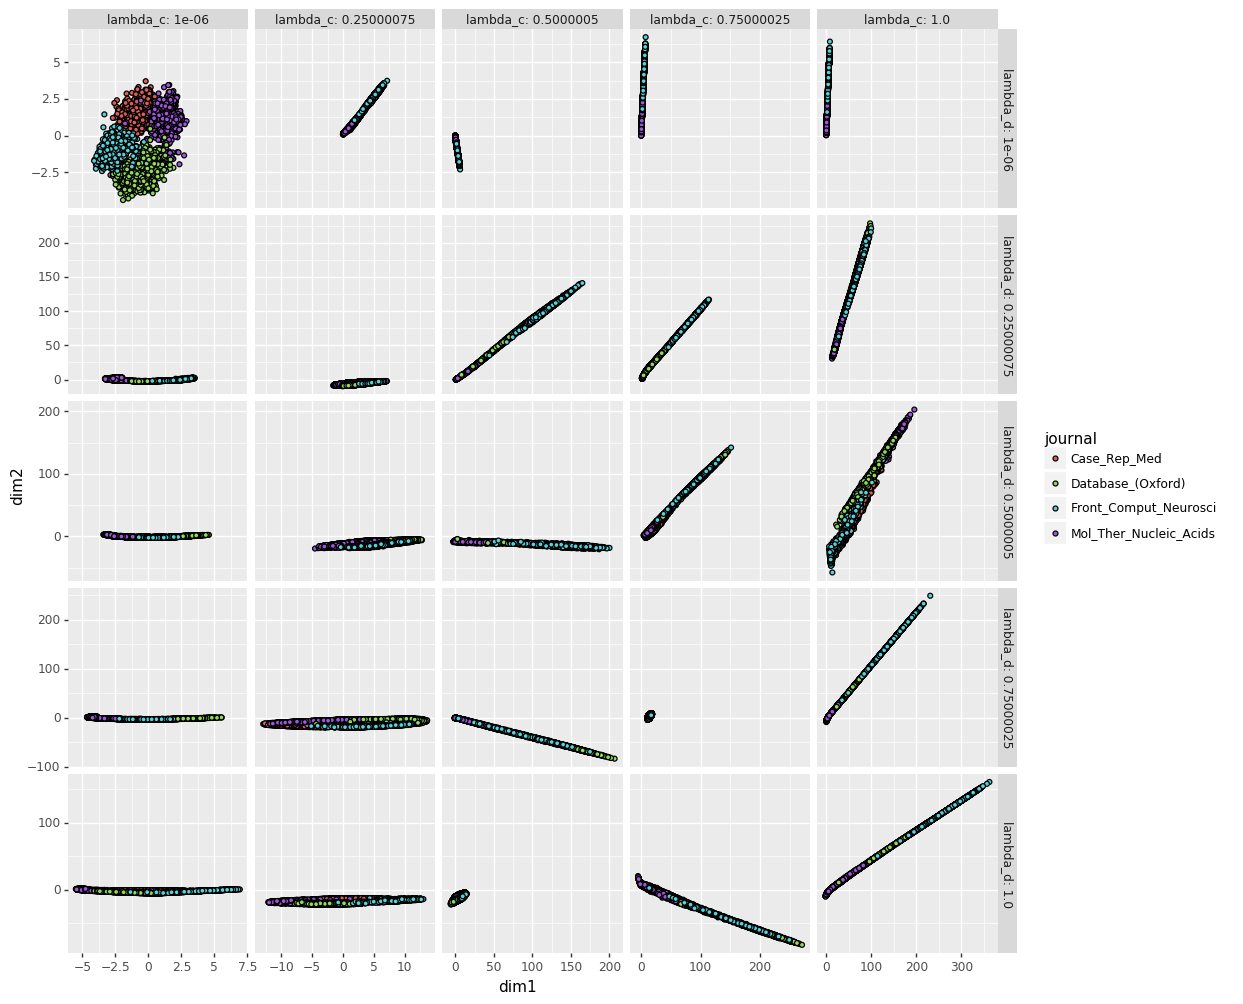

<ggplot: (-9223363304759541984)>


In [13]:
g = (
    p9.ggplot(plot_df)
    + p9.aes(x="dim1", y="dim2", fill = "journal")
    + p9.facet_grid("lambda_d ~ lambda_c", labeller="label_both", scales="free")
    + p9.geom_point()
    + p9.theme(
        figure_size=(12, 12)
    )
)
print(g)

In [14]:
lambda_c_grid = np.linspace(1e-6, 1e-3, num=5)
lambda_d_grid = np.linspace(1e-6, 1e-3, num=5)

In [15]:
plot_df = run_saucie_param_grid(
    full_paper_dataset_subset,
    lambda_c_grid=lambda_c_grid,
    lambda_d_grid=lambda_d_grid
)

25it [05:24, 12.98s/it]


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 12 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/saucie_hyperparam_lambda_cd.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


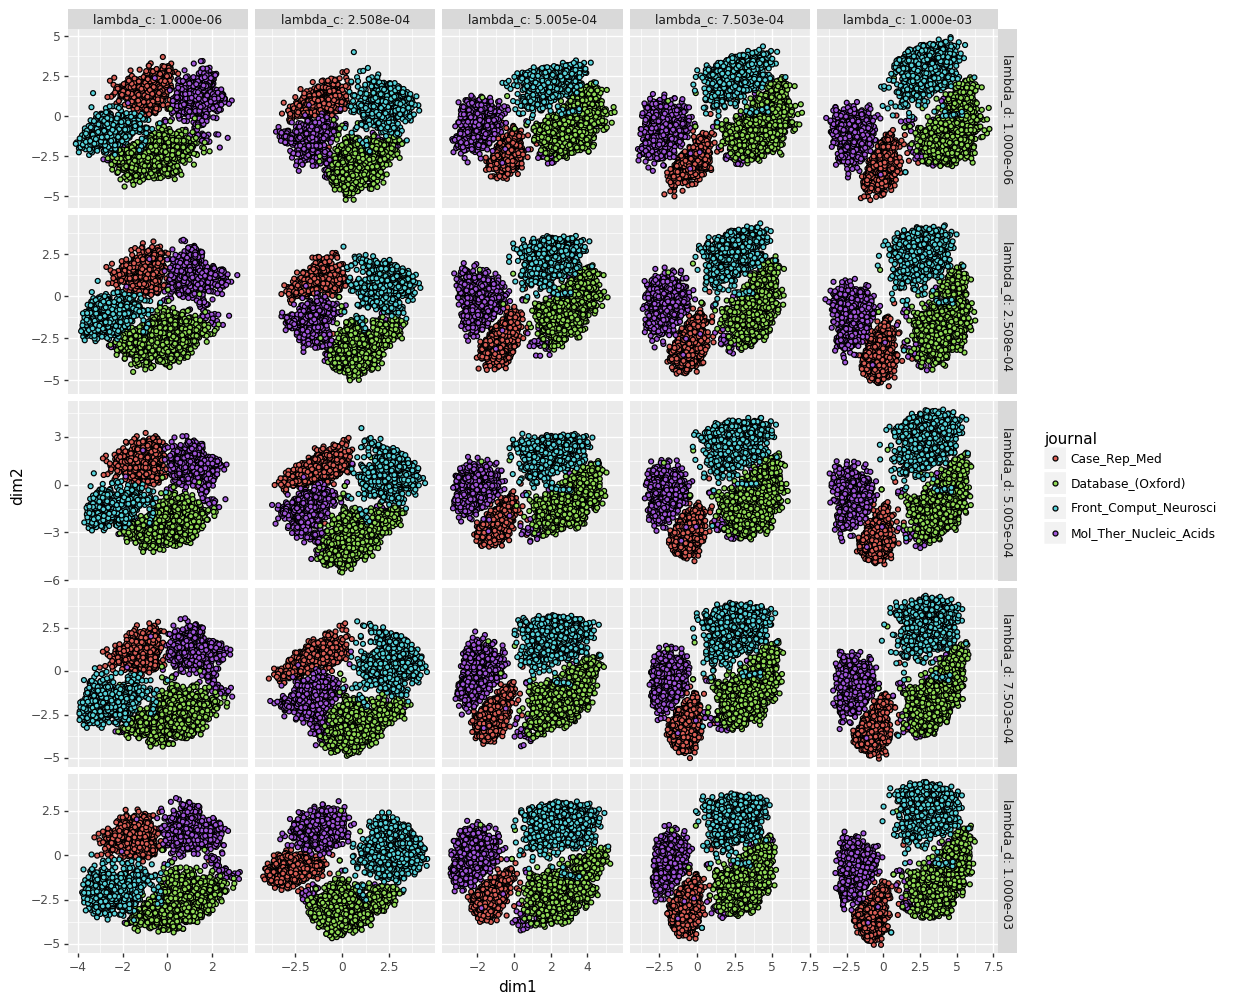

<ggplot: (8731790511638)>


In [16]:
g = (
    p9.ggplot(plot_df)
    + p9.aes(x="dim1", y="dim2", fill = "journal")
    + p9.facet_grid(
        "lambda_d ~ lambda_c", 
        labeller=p9.labeller(
            cols=lambda s:f"lambda_c: {float(s):.3e}",
            rows=lambda s:f"lambda_d: {float(s):.3e}"
        ),
        scales="free"
    )
    + p9.geom_point()
    + p9.theme(
        figure_size=(12, 12)
    )
)
g.save("output/figures/saucie_hyperparam_lambda_cd.png", dpi=500)
print(g)

In [17]:
learning_rate_grid = np.linspace(1e-6, 1e-3, num=3)
steps_grid = [1000, 3000, 5000, 10000, 10000]

In [18]:
plot_df = run_saucie_param_grid(
    full_paper_dataset_subset,
    lambda_c_grid=[1.000e-3],
    lambda_d_grid=[1.000e-3], 
    steps_grid=steps_grid,
    learning_rate_grid=learning_rate_grid
)

15it [17:51, 71.43s/it]


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 12 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/saucie_hyperparam_lr_steps.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


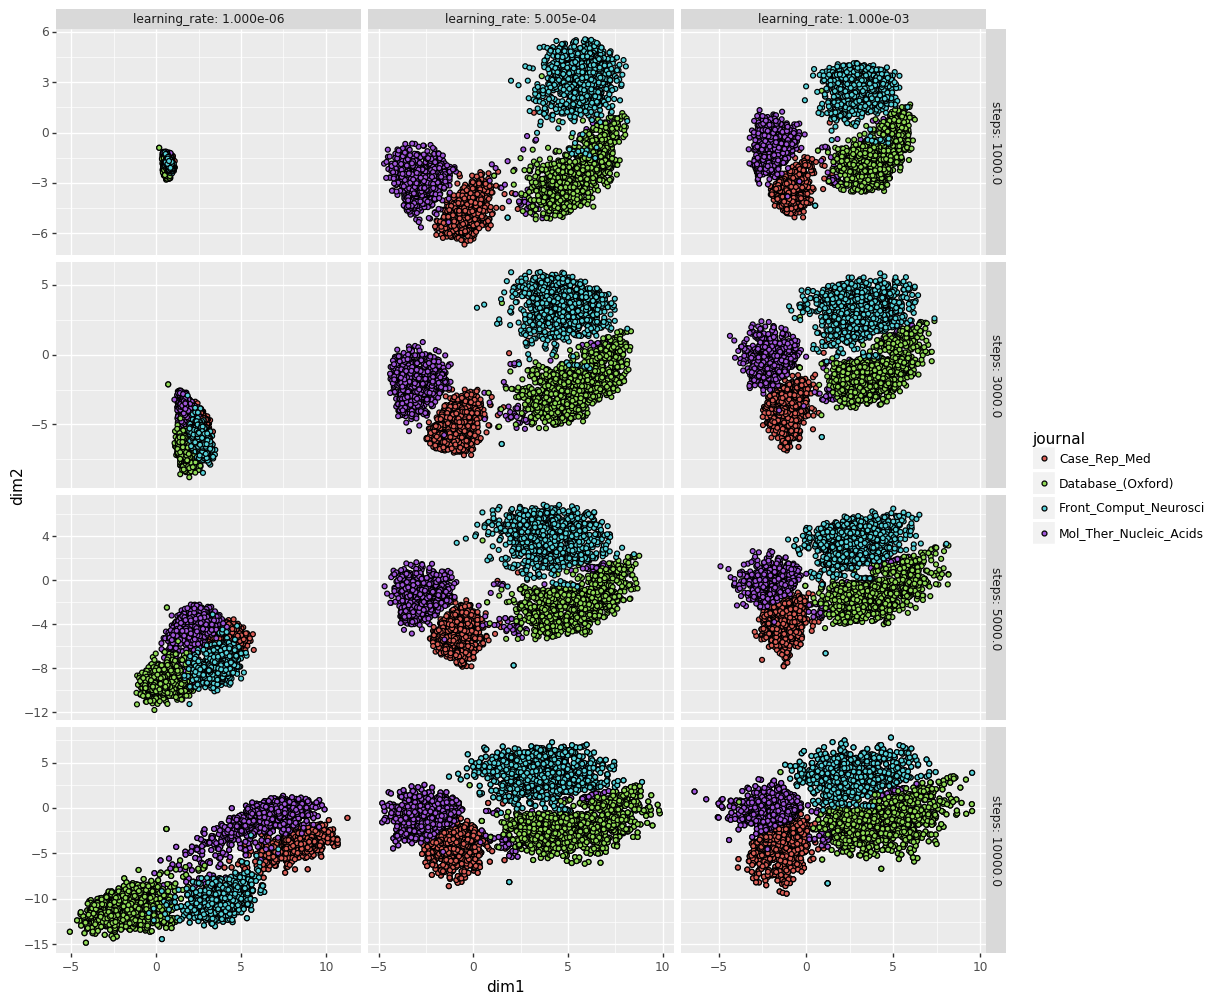

<ggplot: (-9223363304766653766)>


In [19]:
g = (
    p9.ggplot(plot_df)
    + p9.aes(x="dim1", y="dim2", fill = "journal")
    + p9.facet_grid(
        "steps ~ learning_rate", 
        labeller=p9.labeller(
            cols=lambda s:f"learning_rate: {float(s):.3e}",
            rows=lambda s:f"steps: {s}"
        ),
        scales="free"
    )
    + p9.geom_point()
    #+ p9.scale_fill_discrete(guide=False)
    + p9.theme(
        figure_size=(12, 12)
    )
)
g.save("output/figures/saucie_hyperparam_lr_steps.png", dpi=500)
print(g)

In [20]:
set_seeds()

saucie = SAUCIE(
    full_paper_dataset.shape[1]-2, 
    lambda_b=0, lambda_c=1e-3, lambda_d=1e-3,
    learning_rate=1e-3,
    save_folder="output/model"
)

loadtrain = Loader(
    full_paper_dataset.drop(["journal", "document"], axis=1).values, 
    pd.Categorical(full_paper_dataset["journal"].values).codes, 
    shuffle=True
)

saucie.train(loadtrain, steps=10000)
saucie.save()

loadeval = Loader(
    full_paper_dataset.drop(["journal", "document"], axis=1).values, 
    pd.Categorical(full_paper_dataset["journal"].values).codes, 
    shuffle=False
)
embedding = saucie.get_embedding(loadeval)
embedding

Model saved to output/model/SAUCIE


(array([[ 6.1713824, -2.734631 ],
        [ 3.7879121,  2.956243 ],
        [ 6.044377 , -5.623827 ],
        ...,
        [ 2.9470992, -2.2240975],
        [ 8.748381 , -9.764252 ],
        [ 5.8851995, -3.9501786]], dtype=float32),
 array([660, 660, 660, ..., 476, 476, 476], dtype=int16))

In [21]:
full_dataset = (
    pd.DataFrame(
        embedding[0], 
        columns=["dim1", "dim2"]
    )
    .assign(
        journal = full_paper_dataset.journal.tolist(),
        document = full_paper_dataset.document.tolist()
    )
)

full_dataset.to_csv(
    Path("output/paper_dataset")/
    Path("paper_dataset_full_tsne.tsv"),
    sep="\t", index=False
)

full_dataset.head()

,dim1,dim2,journal,document
0,6.171382,-2.734631,Environ_Health,PMC1552054
1,3.787912,2.956243,Environ_Health,PMC1226148
2,6.044377,-5.623827,Environ_Health,PMC5635510
3,9.605969,-3.003096,Environ_Health,PMC3125232
4,6.118244,-4.301338,Environ_Health,PMC3533997


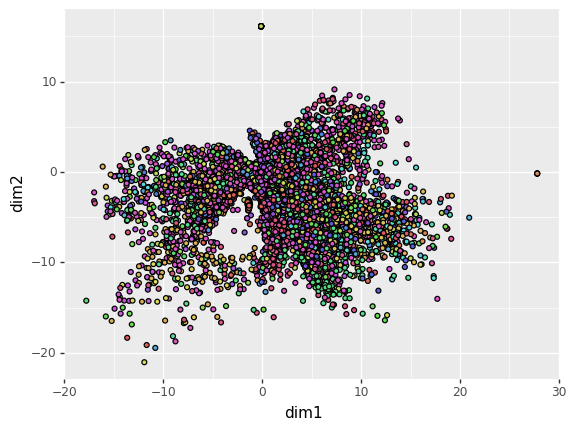

<ggplot: (-9223363305105198469)>


In [22]:
g = (
    p9.ggplot(full_dataset.sample(10000, random_state=100))
    + p9.aes(x="dim1", y="dim2", fill="journal")
    + p9.geom_point()
    + p9.scale_fill_discrete(guide=False)
)
print(g)

# Generate Bin plots

## Square Plot

In [23]:
data_df = pd.read_csv(
    Path("output")/
    Path("paper_dataset")/
    Path("paper_dataset_full_tsne.tsv"), 
    sep="\t"
)
data_df.head()

,dim1,dim2,journal,document
0,6.171382,-2.734631,Environ_Health,PMC1552054
1,3.787912,2.956243,Environ_Health,PMC1226148
2,6.044377,-5.623827,Environ_Health,PMC5635510
3,9.605969,-3.003096,Environ_Health,PMC3125232
4,6.118244,-4.301338,Environ_Health,PMC3533997


In [24]:
data_df.describe()

,dim1,dim2
count,1.726156e+06,1.726156e+06
mean,2.026015e+00,-2.575144e+00
std,5.013000e+00,3.765416e+00
min,-2.160721e+01,-2.528044e+01
25%,-7.336404e-02,-4.387724e+00
50%,1.855069e+00,-2.307549e+00
75%,4.848476e+00,-2.952476e-01
max,2.780187e+01,1.611622e+01


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "journal". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "document". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))


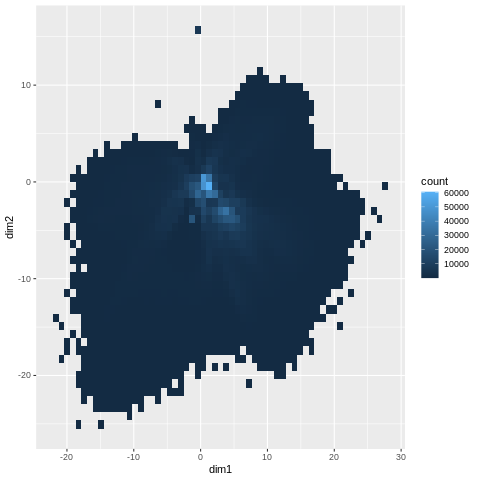

In [25]:
%%R -i data_df -o square_plot_df

library(ggplot2)

bin_num <- 50
g <- (
    ggplot(data_df, aes(x=dim1, y=dim2))
    + geom_bin2d(bins=bin_num, binwidth=0.85)
    + theme(legend.position="left")
)
square_plot_df <- ggplot_build(g)$data[[1]]
print(g)

In [26]:
print(square_plot_df.shape)
square_plot_df.head()

(1478, 22)


,fill,xbin,ybin,value,x,y,count,ncount,density,ndensity,...,xmin,xmax,ymin,ymax,colour,size,linetype,alpha,width,height
1,#132B43,5,1,1.0,-18.275,-25.075,1.0,0.000017,5.793219e-07,0.000017,...,-18.70,-17.85,-25.50,-24.65,-2147483648,0.1,1.0,-2147483648,-2147483648,-2147483648
2,#132B43,9,1,1.0,-14.875,-25.075,1.0,0.000017,5.793219e-07,0.000017,...,-15.30,-14.45,-25.50,-24.65,-2147483648,0.1,1.0,-2147483648,-2147483648,-2147483648
3,#132B43,14,2,38.0,-10.625,-24.225,38.0,0.000627,2.201423e-05,0.000627,...,-11.05,-10.20,-24.65,-23.80,-2147483648,0.1,1.0,-2147483648,-2147483648,-2147483648
4,#132B43,8,3,2.0,-15.725,-23.375,2.0,0.000033,1.158644e-06,0.000033,...,-16.15,-15.30,-23.80,-22.95,-2147483648,0.1,1.0,-2147483648,-2147483648,-2147483648
5,#132B43,9,3,5.0,-14.875,-23.375,5.0,0.000083,2.896610e-06,0.000083,...,-15.30,-14.45,-23.80,-22.95,-2147483648,0.1,1.0,-2147483648,-2147483648,-2147483648


In [27]:
full_paper_dataset = pd.read_csv(
    Path("output/paper_dataset")/
    Path("paper_dataset_full.tsv.xz"),
    sep="\t"
)
print(full_paper_dataset.shape)
full_paper_dataset.head()

(1726156, 302)


,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,Environ_Health,PMC1552054,-0.428596,0.004477,-0.153677,0.059131,-0.394598,-0.066383,0.358798,-0.245809,...,-0.067994,0.033121,-0.077121,-0.433617,-1.111247,-0.405260,0.293903,0.613155,-0.500204,-0.214057
1,Environ_Health,PMC1226148,-0.434013,-0.185516,-0.070654,0.488759,-0.280275,0.042681,0.116685,0.037062,...,0.318905,-0.065244,0.159258,-0.380412,-0.665559,-0.485417,0.180982,0.523053,-0.485158,-0.251244
2,Environ_Health,PMC5635510,-0.248388,0.118660,-0.103008,0.267721,0.278939,-0.220584,0.089593,-0.159638,...,0.081127,-0.110091,-0.031617,-0.188741,-0.936947,-0.461118,0.618781,0.647195,-0.270240,-0.409643
3,Environ_Health,PMC3125232,-0.507224,0.024099,-0.039696,-0.171992,0.371326,-0.137797,-0.202616,-0.156994,...,-0.218274,-0.022597,-0.028885,-0.250560,-1.140730,-0.568136,0.482088,0.899122,-0.250971,-0.592976
4,Environ_Health,PMC3533997,-0.424435,0.175519,-0.048797,0.178023,-0.042913,-0.282377,0.317917,-0.007002,...,-0.111805,-0.262620,-0.187817,-0.463804,-1.308874,-0.352892,0.251982,0.550853,-0.659678,-0.614042


In [28]:
pca_components_df = pd.read_csv(
    Path("../../biorxiv")/
    Path("pca_association_experiment")/
    Path("output")/
    Path("word_pca_similarity")/
    Path("pca_components.tsv"),
    sep="\t"
)
print(pca_components_df.shape)
pca_components_df.head()

(50, 300)


,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,-0.063058,-0.031987,0.056669,0.060172,0.051338,0.000702,-0.036021,-0.048121,0.012963,0.081663,...,-0.075332,-0.049486,-0.006447,0.034889,-0.030875,-0.022924,0.044628,0.079822,-0.006788,-0.097747
1,-0.027159,0.026662,0.029738,-0.114572,-0.073464,0.010639,0.066597,0.047968,-0.029194,-0.106212,...,-0.004370,0.024299,-0.044685,0.029420,-0.022982,0.004105,0.018769,0.056500,0.104248,0.086035
2,0.051539,0.096684,0.075631,-0.080821,-0.018708,0.026179,0.098675,-0.045142,0.025622,0.096555,...,-0.026226,0.090037,-0.065594,-0.039290,-0.122291,-0.048111,0.043212,0.003178,0.078463,-0.078340
3,0.028913,0.045534,-0.041061,-0.057960,0.075108,0.019520,-0.061518,-0.062363,0.016611,-0.066524,...,-0.024171,0.078107,-0.031124,0.124928,-0.001915,0.134990,0.132208,-0.069076,0.085626,0.015349
4,-0.108193,-0.015217,-0.025340,-0.057654,0.097232,0.020200,-0.069443,-0.048466,-0.016571,-0.014490,...,0.038276,0.010970,0.058624,0.088282,-0.031494,-0.047169,-0.004626,0.120189,0.075799,-0.003777


In [29]:
mapped_data_df = pd.DataFrame(
    [], 
    columns=data_df.columns.tolist()+['squarebin_id']
)
square_bin_records = []

for idx, (row_idx, square_bin) in tqdm(enumerate(square_plot_df.iterrows())):
    
    top_left = (square_bin["xmin"], square_bin["ymax"])
    bottom_right = (square_bin["xmax"], square_bin["ymin"])
    
    datapoints_df = (
        data_df
        .query(f"dim1 > {top_left[0]} and dim1 < {bottom_right[0]}")
        .query(f"dim2 < {top_left[1]} and dim2 > {bottom_right[1]}")
    )
    
    # sanity check that I'm getting the coordinates correct
    assert datapoints_df.shape[0] == square_bin["count"]
    
    bin_pca_dist = 1 - cdist(
        pca_components_df, 
        (
            full_paper_dataset
            .query(f"document in {datapoints_df.document.tolist()}")
            .drop(["journal", "document"], axis=1)
            .mean(axis=0)
            .values
            [:, np.newaxis]
            .T
        ),
        "cosine"
    )

    pca_sim_df = (
        pd.DataFrame({
            "score":bin_pca_dist[:,0], 
            "pc":[f"0{dim+1}" if dim+1 < 10 else f"{dim+1}" for dim in range(50)]
        })
    )

    pca_sim_df = (
        pca_sim_df
        .reindex(
            pca_sim_df
            .score
            .abs()
            .sort_values(ascending=False)
            .index
        )
    )

    square_bin_records.append({
        "x": square_bin["x"], "y":square_bin["y"], 
        "xmin":square_bin["xmin"], "xmax":square_bin["xmax"],
        "ymin":square_bin["ymin"], "ymax":square_bin["ymax"],
        "count":datapoints_df.shape[0], "bin_id":idx,
        "pc":pca_sim_df.to_dict(orient="records"),
        "journal":dict(
            Counter(datapoints_df.journal.tolist())
            .items()
        )
    })

    mapped_data_df = (
        mapped_data_df
        .append(
            datapoints_df
            .assign(squarebin_id=idx)
            .reset_index(drop=True),
            ignore_index=True
        )
    )


1478it [04:51,  5.07it/s]


In [30]:
mapped_data_df.head()

,dim1,dim2,journal,document,squarebin_id
0,-18.124933,-24.866093,Cancer_Inform,PMC2675495,0
1,-14.685319,-25.280441,Proteomics,PMC4230411,1
2,-10.546060,-24.527090,Chemphyschem,PMC5129479,2
3,-10.546060,-24.527090,Chembiochem,PMC4736454,2
4,-10.546060,-24.527090,ChemistryOpen,PMC5715300,2


In [31]:
mapped_data_df.to_csv(
    Path("output")/
    Path("paper_dataset")/
    Path("paper_dataset_tsne_square.tsv"), 
    sep="\t", index=False
) 

In [32]:
square_map_df = pd.DataFrame.from_records(square_bin_records)
square_map_df.head()

,x,y,xmin,xmax,ymin,ymax,count,bin_id,pc,journal
0,-18.275,-25.075,-18.70,-17.85,-25.50,-24.65,1,0,"[{'score': 0.3609571260790869, 'pc': '01'}, {'...",{'Cancer_Inform': 1}
1,-14.875,-25.075,-15.30,-14.45,-25.50,-24.65,1,1,"[{'score': 0.5555347419375329, 'pc': '01'}, {'...",{'Proteomics': 1}
2,-10.625,-24.225,-11.05,-10.20,-24.65,-23.80,38,2,"[{'score': 0.6018766422155829, 'pc': '01'}, {'...","{'Chemphyschem': 1, 'Chembiochem': 1, 'Chemist..."
3,-15.725,-23.375,-16.15,-15.30,-23.80,-22.95,2,3,"[{'score': 0.575093618005645, 'pc': '01'}, {'s...","{'Glob_Chall': 1, 'Adv_Sci_(Weinh)': 1}"
4,-14.875,-23.375,-15.30,-14.45,-23.80,-22.95,5,4,"[{'score': 0.4791479219086432, 'pc': '01'}, {'...","{'Neth_Heart_J': 1, 'Genome_Biol': 2, 'J_Biol_..."


In [33]:
square_map_df.to_json(
    Path("output")/
    Path("app_plots")/
    Path("pmc_square_plot.json"),
    orient = 'records',
    lines = False
)